In [14]:
import pandas as pd
import numpy as np
from scipy import sparse
import time
import pickle
import gradio as gr

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

c:\Users\Nick\.conda\envs\recsys_movie\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1) Model building: Latent Dirichlet Allocation

LDA code was adapted from: 

https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

Authors: Olivier Grisel, Lars Buitinck, Chyi-Kwei Yau

License: BSD 3 clause

In [21]:
def plot_top_words(model, feature_names, n_top_words, n_components, title):
    fig, axes = plt.subplots(
        int(np.ceil(n_components / 5)),
        5,
        figsize=(30, 30 * n_components / 20),
        sharex=True,
    )
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

def movie_rec(movie_name, rating_min, is_adult):
    # compute top 5 movie recommendations for the input movie and filters
    # inputs:
    #       movie_name: selected movie_name from radio
    #       rating_min: filter out all movies with ratings less than rating_min
    #       is_adult: if True then filter out adult titles
    # ouputs:
    #       df_in: dataframe with all the info on movie_name
    #       df_out: dataframe with all the info on top 5 recommended movies

    if not movie_name:
        raise gr.Error("Please select a movie before clicking Recommend")

    jmovie = df[df["movie_title"] == movie_name].index[0]
    sim_in = Xtran[jmovie, :].reshape(1, Xtran.shape[1])

    if "NULL" in df["imdb_link"].iloc[jmovie]:
        # input movie has no matching IMDb title
        link_in = ["N/A"]
        genre_in = ["N/A"]
        rating_in = ["N/A"]
    else:
        # link_in = construct_markdown_link([df["imdb_link"].iloc[jmovie]], [movie_name])
        genre_in = [df["genre"].iloc[jmovie]]
        rating_in = [df["average_rating"].iloc[jmovie]]

    # construct input dataframe
    df_in = pd.DataFrame(
        {
            "Title": [movie_name],
            "Year": [df["movie_year"].iloc[jmovie]],
            "IMDb Rating": rating_in,
            "Genres": genre_in,
            # "IMDb Link": link_in,
        }
    )

    # compute similarity between movie_name and all other movies in database
    sim_movie = cosine_similarity(sim_in, Xtran).reshape((len(df),))

    # sort dataframe by movie similarity in descending order
    arg_sim_movie_ordered = np.flip(np.argsort(sim_movie))
    df_sort = df.iloc[arg_sim_movie_ordered[1:]]

    # fiter by rating_min and is_adult
    df_sort = df_sort[df_sort["average_rating"] >= float(rating_min)]
    if is_adult:
        df_sort = df_sort[df_sort["is_adult"] == 0]

    # raise error if less than 5 movies are left after filtering
    if len(df_sort) < 5:
        raise gr.Error(
            "Not enough movies met the filter criteria. Try reducing the minimum rating."
        )

    # construct output dataframe
    movie_title = df_sort["movie_title"].iloc[0:5].tolist()
    movie_year = df_sort["movie_year"].iloc[0:5].tolist()
    rating = df_sort["average_rating"].iloc[0:5].tolist()
    genre = df_sort["genre"].iloc[0:5].tolist()
    # link = construct_markdown_link(df_sort["imdb_link"].iloc[0:5].tolist(), movie_title)

    df_out = pd.DataFrame(
        {
            "Title": movie_title,
            "Year": movie_year,
            "IMDb Rating": rating,
            "Genres": genre,
            # "IMDb Link": link,
        }
    )

    return df_in, df_out

## 1a) Hyperparameter selection - number of topics to choose

In [6]:
# model inputs
n_samples = 500
n_components = 20
n_top_words = 20

# data preprocessing exports for model building
from scipy import sparse

# read in movie database
df = pd.read_csv("data_preprocessing_eda_out\\df_spaces_upload.csv", index_col=[0])

# read in scipy sparse matrix
X = sparse.load_npz("data_preprocessing_eda_out\\X.npz")

with open("data_preprocessing_eda_out\\word_key.txt", "rb") as f:
    word_key = pickle.load(f)

n_movies = len(df)
n_features = len(word_key)

In [7]:
# construct train/test split
jdocs = np.random.permutation(np.arange(n_movies))[0:n_samples]

In [8]:
# fit LDA model

# took 90 minutes (~1.75 minutes/iteration) on 10,000 words, 20 components, 10177 randomly chosen samples, 52 iterations, perplexity dropped <0.1/iteration at 52th iteration
print(
    f"Fitting LDA models with tf features, n_samples={n_samples} and n_features={n_features}..."
)
lda = LatentDirichletAllocation(
    n_components=n_components,  # x4 components 2.5x the time
    max_iter=10,  # x2 iterations 2x the time
    learning_decay=0.55,
    learning_method="online",
    learning_offset=64.0,
    batch_size=256,
    random_state=0,
    evaluate_every=5,
    verbose=1,
)
t0 = time.time()
lda.fit(X[jdocs, :])  # scales (roughly) linearly with number of training examples
print("done in %0.3fs." % (time.time() - t0))

Fitting LDA models with tf features, n_samples=500 and n_features=10000...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10, perplexity: 4590.9780
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10, perplexity: 4011.5958
done in 53.069s.


## 1b) Model evaluation

In [9]:
# predict topic weights for all scripts in the database (4 minutes for the entire corpus)
# this will be precomputed and saved to be used for recommender app predicitons
Xtran = lda.transform(X)

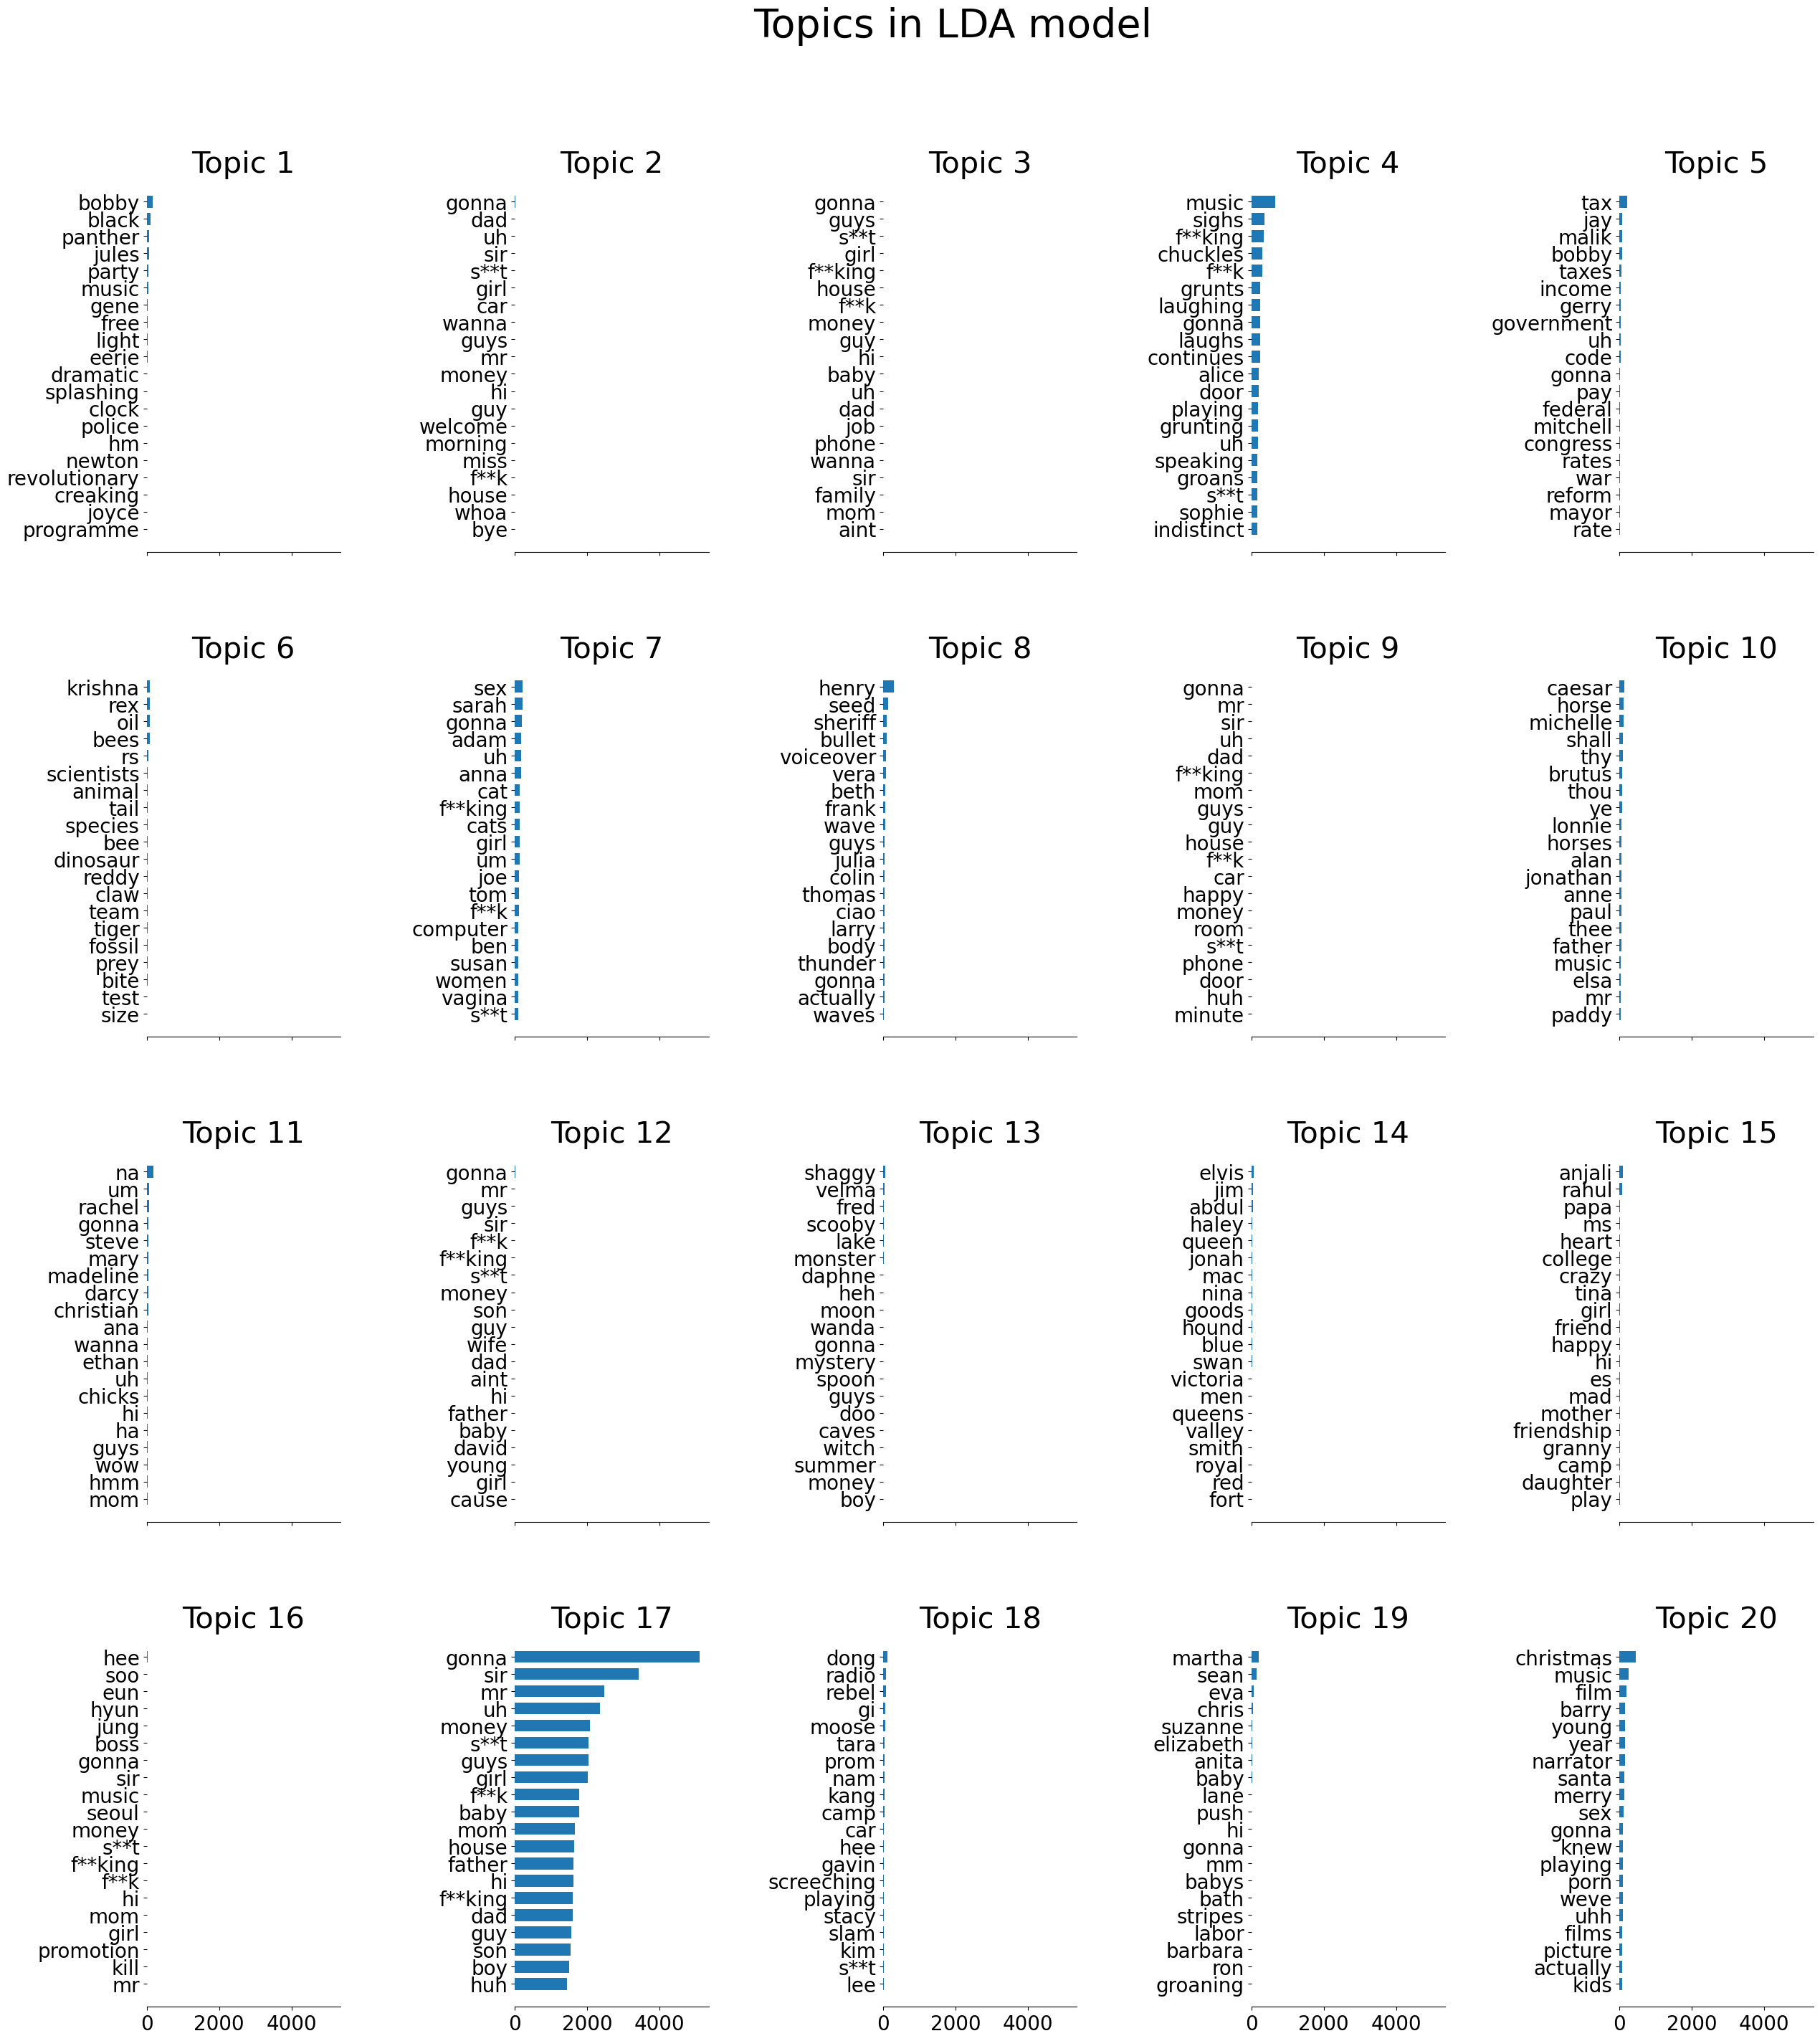

In [22]:
plot_top_words(lda, word_key, n_top_words, n_components, "Topics in LDA model")

In [31]:
# define some test cases - will be used as examples in app
tested_examples = [
    ["Inception", "3", True],
    ["Finding Nemo", "6", True],
    ["How to Train Your Dragon", "6.7", True],
    ["Remember the Titans", "7.1", True],
    ["Avengers: Endgame", "6.5", True],
    ["Mean Girls", "6.1", True],
]

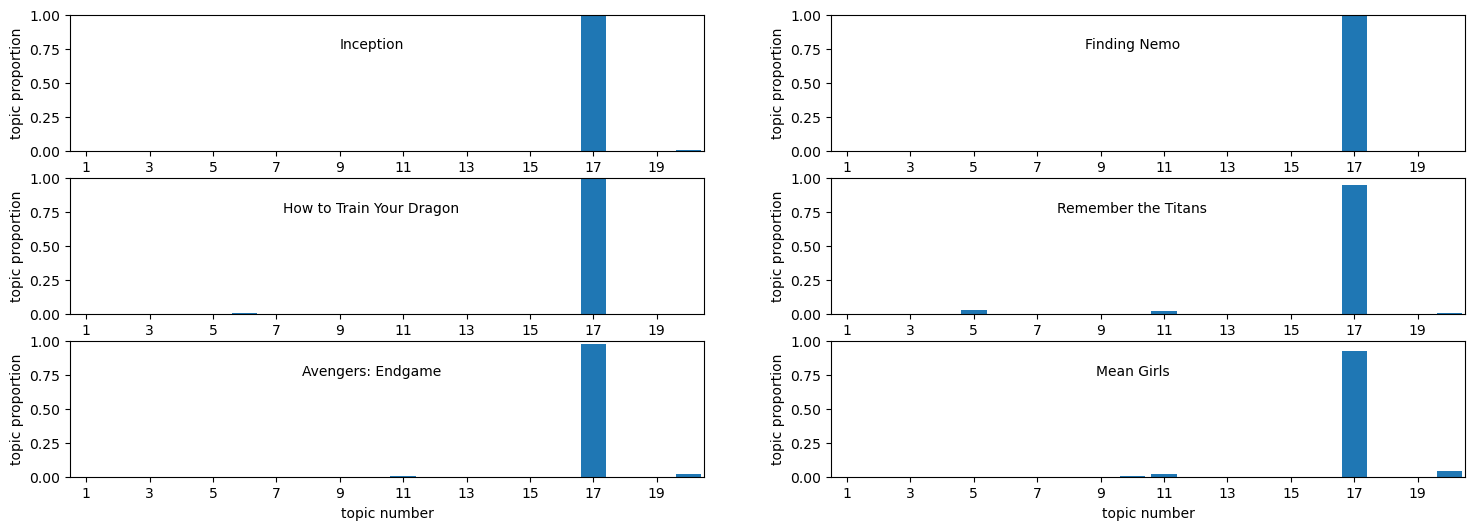

In [24]:
# visualize the topic distribution for tested_examples

# plot distribution of topic weights
fig, ax = plt.subplots(3, 2, figsize=(18, 6))
ax = ax.flatten()
for j, ex in enumerate(tested_examples):
    jmovie = df[df["movie_title"] == ex[0]].index[0]
    prob_height = np.round(Xtran[jmovie, :].reshape(1, n_components), 3).reshape(-1)
    ax[j].bar(x=list(range(1, n_components + 1)), height=prob_height)
    ax[j].set_ylim(0, 1)
    ax[j].set_xlim(0.5, n_components + 0.5)
    ax[j].set_ylabel("topic proportion")
    ax[j].set_xlabel("topic number")
    ax[j].set_xticks(list(range(1, n_components + 1, 2)))
    ax[j].text(n_components / 2, 0.75, ex[0], ha="center")

# 2) Model prediction and ranking of recommendations

In [32]:
# run recommender algorithm and view results
for ex in tested_examples:
    df_in, df_out = movie_rec(movie_name=ex[0], rating_min=ex[1], is_adult=ex[2])

    print("Input Movie:")
    print(df_in.to_markdown())
    print()
    print("Recommended Movies:")
    print(df_out.to_markdown())
    print("\n\n")

Input Movie:
|    | Title     |   Year |   IMDb Rating | Genres                  |
|---:|:----------|-------:|--------------:|:------------------------|
|  0 | Inception |   2010 |           8.8 | Action,Adventure,Sci-Fi |

Recommended Movies:
|    | Title              |   Year |   IMDb Rating | Genres                   |
|---:|:-------------------|-------:|--------------:|:-------------------------|
|  0 | The Great Outdoors |   1988 |           6.6 | Comedy                   |
|  1 | Three Little Words |   1950 |           6.9 | Biography,Comedy,Musical |
|  2 | Camino, 2008       |   2008 |           7.4 | Drama                    |
|  3 | Remember Me        |   2010 |           7.1 | Drama,Romance            |
|  4 | Day Zero, 2007     |   2007 |           5.9 | Drama                    |



Input Movie:
|    | Title        |   Year |   IMDb Rating | Genres                     |
|---:|:-------------|-------:|--------------:|:---------------------------|
|  0 | Finding Nemo |   2003

Error: 'Not enough movies met the filter criteria. Try reducing the minimum rating.'

# model exports

In [30]:
pickle.dump(lda, open('model_building_and_eval\\model_2023_08_15.sav', 'wb'))
with open('jX_train.txt', 'wb') as f:
    pickle.dump(jX_train,f)    


with open('model_building_and_eval\\Xtran.txt', 'wb') as f:
    pickle.dump(Xtran,f)    